In [283]:
import matplotlib.pyplot as plt
from enum import Enum
import numpy as np

CustomerStatus = Enum("CustomerStatus", ["no_taxi", "waiting", "inside", "end"])
TaxiStatus = Enum("CustomerStatus", ["going_to_customer", "has_customer", "free", "stopped"])

In [228]:
INITIAL_FEE = 5
LENGTH_FEE = 2

In [229]:
class Taxi:
    def __init__(self, current_vertex):
        self.status = "free"
        self.total_income = 0
        self.total_distance = 0
        self.current_vertex = current_vertex
        self.n_customers = 0
        # we can add time counter and increment in make 

In [230]:
class Customer:
    def __init__(self, current_vertex, destination_vertex):
        self.status: CustomerStatus = "no_taxi"
        self.current_vertex = current_vertex
        self.destination_path = None
        self.destination_vertex = destination_vertex
        self.assigned_taxi = None
        self.pickup_path = None

In [293]:
class TaxiService:
    def __init__(self, graph):
        self.customers: list[Customer] = []
        self.graph = graph
        
        self.taxis: dict[str, Taxi] = {}
        self.taxis_in_vertices = {k: [] for k in graph.keys()}  # all vertices with current taxis, need to check if there are free taxis
        self.customers_in_vertices = {k: [] for k in graph.keys()}
        
        for i in range(5):
            self.generate_new_taxi()
    
    def assign_taxi_to_customer(self):
        for customer in self.customers:
            if customer.status != "no_taxi":
                continue
            taxi_id, pickup_path = self.find_closest_taxi(customer.current_vertex)
            if taxi_id:
                customer.assigned_taxi = taxi_id
                customer.pickup_path = pickup_path
                customer.status = "waiting"
                self.taxis[taxi_id].status = "going_to_customer"
                self.taxis[taxi_id].n_customers += 1
                self.taxis[taxi_id].total_income += INITIAL_FEE
            else:
                return
    
    def find_closest_taxi(self, customer_vertex):
        predecessors = {customer_vertex: None}
        visited = {customer_vertex}
        queue = [customer_vertex]
        while queue:
            cur_ver = queue.pop(0)
            for taxi in self.taxis_in_vertices[cur_ver]:
                if self.taxis[taxi].status == "free":
                    res = predecessors[cur_ver]
                    
                    path = [] 
                    while res:
                        path.append(res)
                        res = predecessors[res]
                        
                    return taxi, path
            for ver_edg in self.graph[cur_ver]:
                if ver_edg not in visited:
                    visited.add(ver_edg)
                    queue.append(ver_edg)
                    predecessors[ver_edg] = cur_ver
        return None, None
    
    def find_destination_path(self, customer_vertex, destination_vertex):
        predecessors = {destination_vertex: None}
        visited = {destination_vertex}
        queue = [destination_vertex]
        while queue:
            cur_ver = queue.pop(0)
            if cur_ver == customer_vertex:
                res = predecessors[cur_ver]
    
                path = []
                while res:
                    path.append(res)
                    res = predecessors[res]
                    
                return path
            
            for ver_edg in self.graph[cur_ver]:
                if ver_edg not in visited:
                    visited.add(ver_edg)
                    queue.append(ver_edg)
                    predecessors[ver_edg] = cur_ver
                    
        return None
        
    
    def generate_new_taxi(self):
        if not self.taxis:
            new_key = "11111"
            self.taxis = {new_key: Taxi("1")}
            self.taxis_in_vertices["1"].append(new_key)
            return 
        new_key = str(int(max(self.taxis.keys())) + 1)
        self.taxis[new_key] = Taxi("1")
        self.taxis_in_vertices["1"].append(new_key)

    def generate_new_customer(self):
        possible_lst = list(self.graph.keys())
        current_vertex = np.random.choice(possible_lst)
        possible_lst.remove(current_vertex)
        destination_vertex = np.random.choice(possible_lst)
    
        customer = Customer(current_vertex, destination_vertex)
        customer.destination_path = self.find_destination_path(current_vertex, destination_vertex)
        
        self.customers.append(customer)
  
        
    def make_step(self):
        # generate new taxis
        for _ in range(3):
            self.generate_new_taxi()
            self.generate_new_taxi()
            self.generate_new_taxi()
        
        
        customer_proba = [0.7, 0.2, 0.1]
        n_new_customers = np.random.choice(list(range(len(customer_proba))), customer_proba)
        
        # generate new customers
        for _ in range(n_new_customers):
            self.generate_new_customer()

        self.assign_taxi_to_customer()
        
        customers_to_delete = []

        for i, customer in enumerate(self.customers):
            if customer.status == "waiting":
                if customer.pickup_path:
                    new_ver = customer.pickup_path.pop(0)
                    customer.current_vertex = new_ver
                    self.taxis[customer.assigned_taxi].current_vertex = new_ver
                    self.taxis[customer.assigned_taxi].total_distance += 1
                else:
                    customer.status = "inside"
            elif customer.status == "inside":
                if customer.destination_path:
                    new_ver = customer.destination_path.pop(0)
                    customer.current_vertex = new_ver
                    self.taxis[customer.assigned_taxi].current_vertex = new_ver
                    self.taxis[customer.assigned_taxi].total_distance += 1
                    self.taxis[customer.assigned_taxi].total_income += LENGTH_FEE
                else:
                    customer.status = "end"
            elif customer.status == "end":
                self.taxis[customer.assigned_taxi].status = "free"
                customers_to_delete.append(i)
        
        for i in customers_to_delete[::-1]:
            del self.customers[i]

In [294]:
g = {
    "1": ["2"],
    "2": ["1", "3", "4"],
    "3": ["2"],
    "4": ["2"]
}

In [295]:
vertex_coordinates = {
    "1": (-1, 0),
    "2": (0, 0),
    "3": (1, 0),
    "4": (0, 1),
}

In [299]:
ts = TaxiService(g)
for _ in range(100):
    ts.make_step()

In [297]:
markers = ["<", ">", "p", "h"]
colors = ["r", "y", "g"]

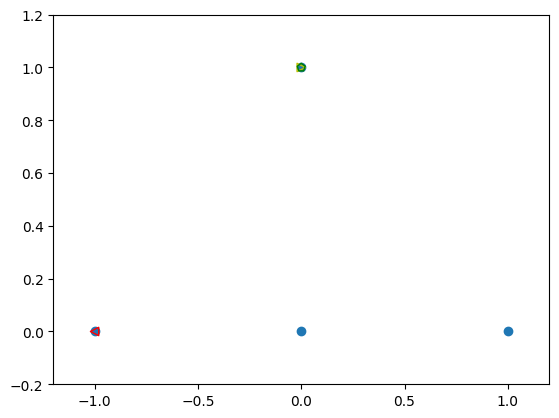

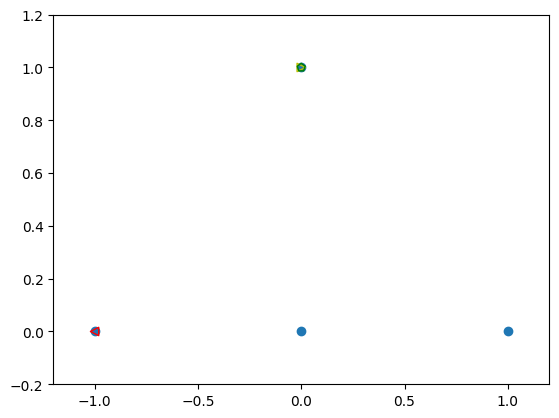

In [282]:
for _ in range(2):
    plt.scatter(*zip(*vertex_coordinates.values()))
    for m, t, c in zip(markers, ts.taxis, colors):
        plt.scatter(*zip(*[vertex_coordinates[ts.taxis[t].current_vertex]]), marker=m, facecolors='none', edgecolors=c)
    plt.xlim([-1.2, 1.2])
    plt.ylim([-0.2, 1.2])
    plt.show()
    
    ts.make_step()

In [243]:
ts.taxis["11111"].total_income

138

In [223]:
ts.customers[1].current_vertex

'4'

In [224]:
ts.customers[1].destination_vertex

'1'

In [225]:
ts.customers[1].destination_path

['2', '1']

In [226]:
ts.customers[0].pickup_path

[]

In [227]:
ts.customers[1].pickup_path

['2', '4']